The provided script is designed for the analysis of collective behavior in nematodes. 

Here we conduct the analysis comparing all the strains belonging to the divergent data set. 

# Load Packages #

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from skimage.measure import label, regionprops
from skimage.draw import circle_perimeter
from math import sqrt
from skimage.io import imread
from skimage.transform import resize
from skimage.filters import threshold_otsu
from tabulate import tabulate
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.image as mpimg
from matplotlib import rcParams
import h5py    # for reading HDF5 files 
import cv2     # for image conversion
import re    # use it to sort but not sure what it is!
from scipy.stats import zscore
from skimage import draw, measure
import pywt
from scipy.spatial.distance import cdist
import seaborn as sns
from scipy.stats import multivariate_normal
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.filters import threshold_otsu
from skimage import color
import glob

# Data extraction #

### Data set infromation overview: ###

1. Divergent Sets:

    Consists of 12 genotypically distinct strains. These are strains that are further apart on the phenotypic tree. 
    Ideal for determining broad-sense heritability with repeated measurements of specific phenotypes.
    This allows us to look into the relationship between the behavior and the genetic makeup. 

2. Mapping Sets:

    Comprises 48 strains suitable for collecting phenotype data for broad diversity or genome-wide association studies.
    Using multiple strain sets can enhance the statistical strength in genome-wide association studies.

### Workflow: Handling and processing image data stored in HDF5 files ###

General steps: 
1. Frame extraction from hdf5 files and saving 

2. Feature extraction from each frame 

3. Analysis of features 

More in detail: 

In hdf5_frames_extractor: 

1. The script sets the paths to your HDF5 files and the directory for extracted frames.

2. It ensures the output directory exists for each strain and each experiment.

3. It retrieves the paths of HDF5 files for each strain and creates corresponding output directories.

4. It extracts frames from HDF5 files and saves them in the respective experiment subfolders.

Strain_comparison_study: 

5. Load Images: Use the load_images_from_folder function to load frames from each experiment.

6. It creates a dictionary labels_strain_list mapping experiment labels to the loaded images.

7. Feature Extraction: Write functions to extract the necessary features from each frame.

8. Aggregate and Analyze: Aggregate the features per experiment, and then perform statistical analyses and visualizations.

9. Comparison: Compare these features across different strains.

### Functions: ###

In [4]:
def select_frames(folder, num_frames):
    image_files = sorted(glob.glob(os.path.join(folder, '*.jpg')))
    total_frames = len(image_files)

    if total_frames <= num_frames:
        selected_frames = image_files
    else:
        indices = np.linspace(0, total_frames - 1, num=num_frames, dtype=int)
        selected_frames = [image_files[i] for i in indices]

    # print(f"Selected {len(selected_frames)} frames from {folder}: {selected_frames}")
    return selected_frames

def extract_experiment_name(file_path):
    # Assuming the experiment's name is part of the file's name
    base_name = os.path.basename(file_path)
    name_parts = base_name.split('_')
    experiment_name = '_'.join(name_parts[:-1])  # Exclude the extension and any other parts
    return experiment_name

def load_selected_images(image_paths):
    selected_images = []
    for filepath in image_paths:
        image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            selected_images.append(image)
    return selected_images

def segment_lighter_areas(image, threshold_value):
    """ Segment lighter areas in the image based on a threshold. """
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray_image, threshold_value, 255, cv2.THRESH_BINARY)

    # Morphological closing to fill small holes within the worms
    closing_kernel = np.ones((5,5), np.uint8)
    thresh_closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, closing_kernel)

    # Morphological opening to separate worms that are close to each other
    opening_kernel = np.ones((3,3), np.uint8)
    thresh_opened = cv2.morphologyEx(thresh_closed, cv2.MORPH_OPEN, opening_kernel)

    return thresh_opened

def calculate_features(image_path, frame_number, threshold_value=100):
    """ Calculate the required features for a given image path and frame number. """
    image = cv2.imread(image_path)  # Read the image from the file path
    if image is None:
        raise ValueError(f"Could not read the image file {image_path}")

    segmented = segment_lighter_areas(image, threshold_value)
    labeled_areas = label(segmented)
    properties = regionprops(labeled_areas)

    image_center = np.array(image.shape[:2][::-1]) / 2

    features = []
    for prop in properties:
        center_of_mass = prop.centroid
        distance_from_center = np.linalg.norm(np.array(center_of_mass) - image_center)
        area = prop.area
        features.append({
            'frame': frame_number,
            'center_of_mass': center_of_mass,
            'distance_from_center': distance_from_center,
            'area': area
        })

    return features


### Image Loading ###

1. Iterates over each strain folder.

2. For each experiment within a strain, it selects a specified number of frames.

3. Prints the selected frames for diagnostics.

4. Extracts features from the selected frames.

5. Loads the selected images and stores them in labels_strain_list.

6. Prints the number of images loaded for each experiment.

In [6]:
# Set the root path where the extracted images are stored
output_root_path = '/Volumes/TOSHIBA_EXT/Phenotype_features_collective/Data/ExtractedFrames'

# Create a dictionary to map experiment labels to images
labels_strain_list = {}
strain_folders = [d for d in os.listdir(output_root_path) if os.path.isdir(os.path.join(output_root_path, d))]

for strain in strain_folders:
    experiment_folders = [os.path.join(output_root_path, strain, e) for e in os.listdir(os.path.join(output_root_path, strain)) if os.path.isdir(os.path.join(output_root_path, strain, e))]
    for folder in experiment_folders:
        selected_frame_paths = select_frames(folder, 3)  # Define 'n' as needed
        selected_images = load_selected_images(selected_frame_paths)
        experiment_label = extract_experiment_name(folder)
        labels_strain_list[experiment_label] = selected_images


# Now 'labels_strain_list' contains the mapping of experiment labels to the loaded images
        
root_path = '/Volumes/TOSHIBA_EXT/Phenotype_features_collective/Data/ExtractedFrames'

# Dictionary to hold features for each experiment, structured by strain
experiment_features = {}

for strain_folder in os.listdir(root_path):
    strain_path = os.path.join(root_path, strain_folder)
    if os.path.isdir(strain_path):
        experiment_features[strain_folder] = {}

        for experiment_folder in os.listdir(strain_path):
            experiment_path = os.path.join(strain_path, experiment_folder)
            if os.path.isdir(experiment_path):
                selected_frame_paths = select_frames(experiment_path, 3)
                experiment_label = extract_experiment_name(experiment_path)

                experiment_features[strain_folder][experiment_label] = []

                for frame_number, frame_path in enumerate(selected_frame_paths):
                    frame_features = calculate_features(frame_path, frame_number)
                    experiment_features[strain_folder][experiment_label].append(frame_features)

                # Load selected images
                selected_images = load_selected_images(selected_frame_paths)
                labels_strain_list[experiment_label] = selected_images


In [12]:
# User can you do this so that it generalizes to any feature estimated in experiment_feature? 
# I am thinking of adding new features to the function calculate_features, so this output may change

# def calculate_average_features_per_frame(experiment_features):
    # average_features_per_frame = {}

    # for strain, experiments in experiment_features.items():
    #     average_features_per_frame[strain] = {}
    #     for exp_label, frames in experiments.items():
    #         # Initialize dictionary to store total and count for each feature
    #         feature_totals = {'distance_from_center': 0, 'area': 0}
    #         feature_counts = {'distance_from_center': 0, 'area': 0}
    #         frame_averages = {'distance_from_center': [], 'area': []}

    #         # Iterate over each frame
    #         for frame_data in frames:
    #             if isinstance(frame_data, dict):
    #                 # Accumulate the values for each feature
    #                 for feature_key in ['distance_from_center', 'area']:
    #                     if feature_key in frame_data and frame_data[feature_key] is not None:
    #                         feature_totals[feature_key] += frame_data[feature_key]
    #                         feature_counts[feature_key] += 1

    #                 # Calculate the average for each feature in the frame
    #                 for feature_key in ['distance_from_center', 'area']:
    #                     if feature_counts[feature_key] > 0:
    #                         average = feature_totals[feature_key] / feature_counts[feature_key]
    #                         frame_averages[feature_key].append(average)
    #                     else:
    #                         frame_averages[feature_key].append(None)
                        
    #                     # Reset totals and counts for the next frame
    #                     feature_totals[feature_key] = 0
    #                     feature_counts[feature_key] = 0

    #         average_features_per_frame[strain][exp_label] = frame_averages

    # return average_features_per_frame

# average_experiment_features_per_frame = calculate_average_features_per_frame(experiment_features)


def print_structure(data_dict):
    if not isinstance(data_dict, dict):
        print("The data is not a dictionary.")
        return

    for key, value in data_dict.items():
        print(f"Key: {key}")
        if isinstance(value, dict):
            for subkey, subvalue in value.items():
                print(f"  Subkey: {subkey}")
                if isinstance(subvalue, dict):
                    for subsubkey, subsubvalue in subvalue.items():
                        print(f"    Subsubkey: {subsubkey}, Value: {subsubvalue}")
                else:
                    print(f"  Value: {subvalue}")
        else:
            print(f"Value: {value}")
        print("-------")  # Just to separate between entries for readability

# Example usage
print_structure(average_experiment_features_per_frame)


KeyError: 0

# Visualization #

### To visualize one frame detected blobs ###

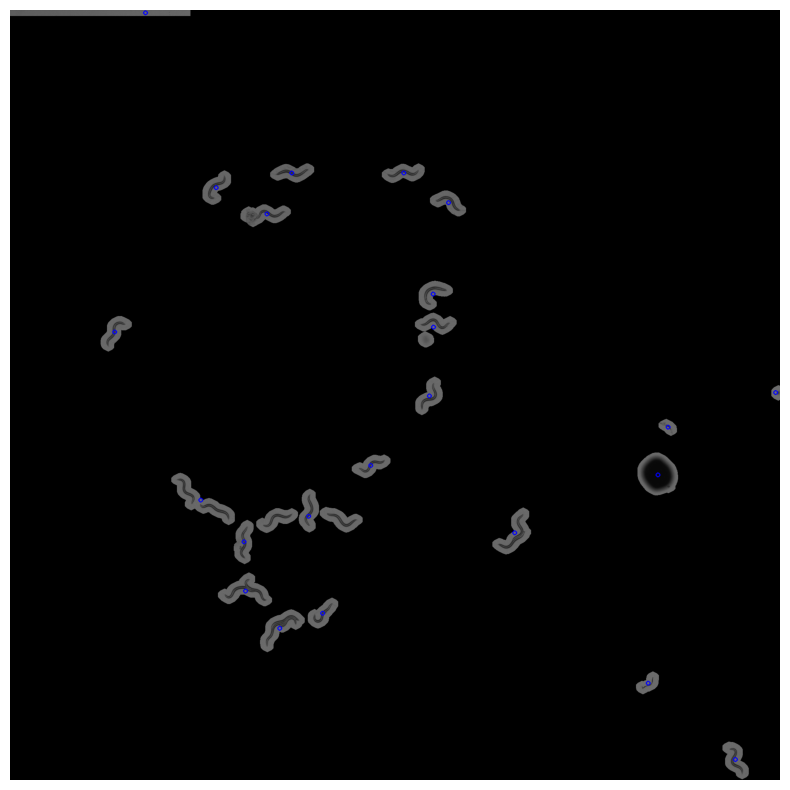

Number of features (center of mass) found: 23


In [10]:
# Assuming calculate_features and segment_lighter_areas are already defined as in your previous code

def visualize_frame_with_features(image_path, threshold_value=100):
    # Calculate features for the image
    features = calculate_features(image_path, threshold_value)

    # Read the image for visualization
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not read the image file {image_path}")

    # Draw circles at the center of mass of each detected object
    for feature in features:
        center_of_mass = feature['center_of_mass']
        cv2.circle(image, (int(center_of_mass[1]), int(center_of_mass[0])), 5, (255, 0, 0), 2)

    # Convert color to RGB (from BGR) for displaying with matplotlib
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # Print the number of features (center of mass) found in the image
    print(f"Number of features (center of mass) found: {len(features)}")


# Example usage
example_image_path = '/Volumes/TOSHIBA_EXT/Phenotype_features_collective/Data/ExtractedFrames/CB4856/1.1_3_cb4856_oo_Set0_Pos0_Ch3_14012018_114743/065500.jpg'  
visualize_frame_with_features(example_image_path)


### Time Series for Each Strain (All Experiments) ###

AttributeError: 'list' object has no attribute 'get'

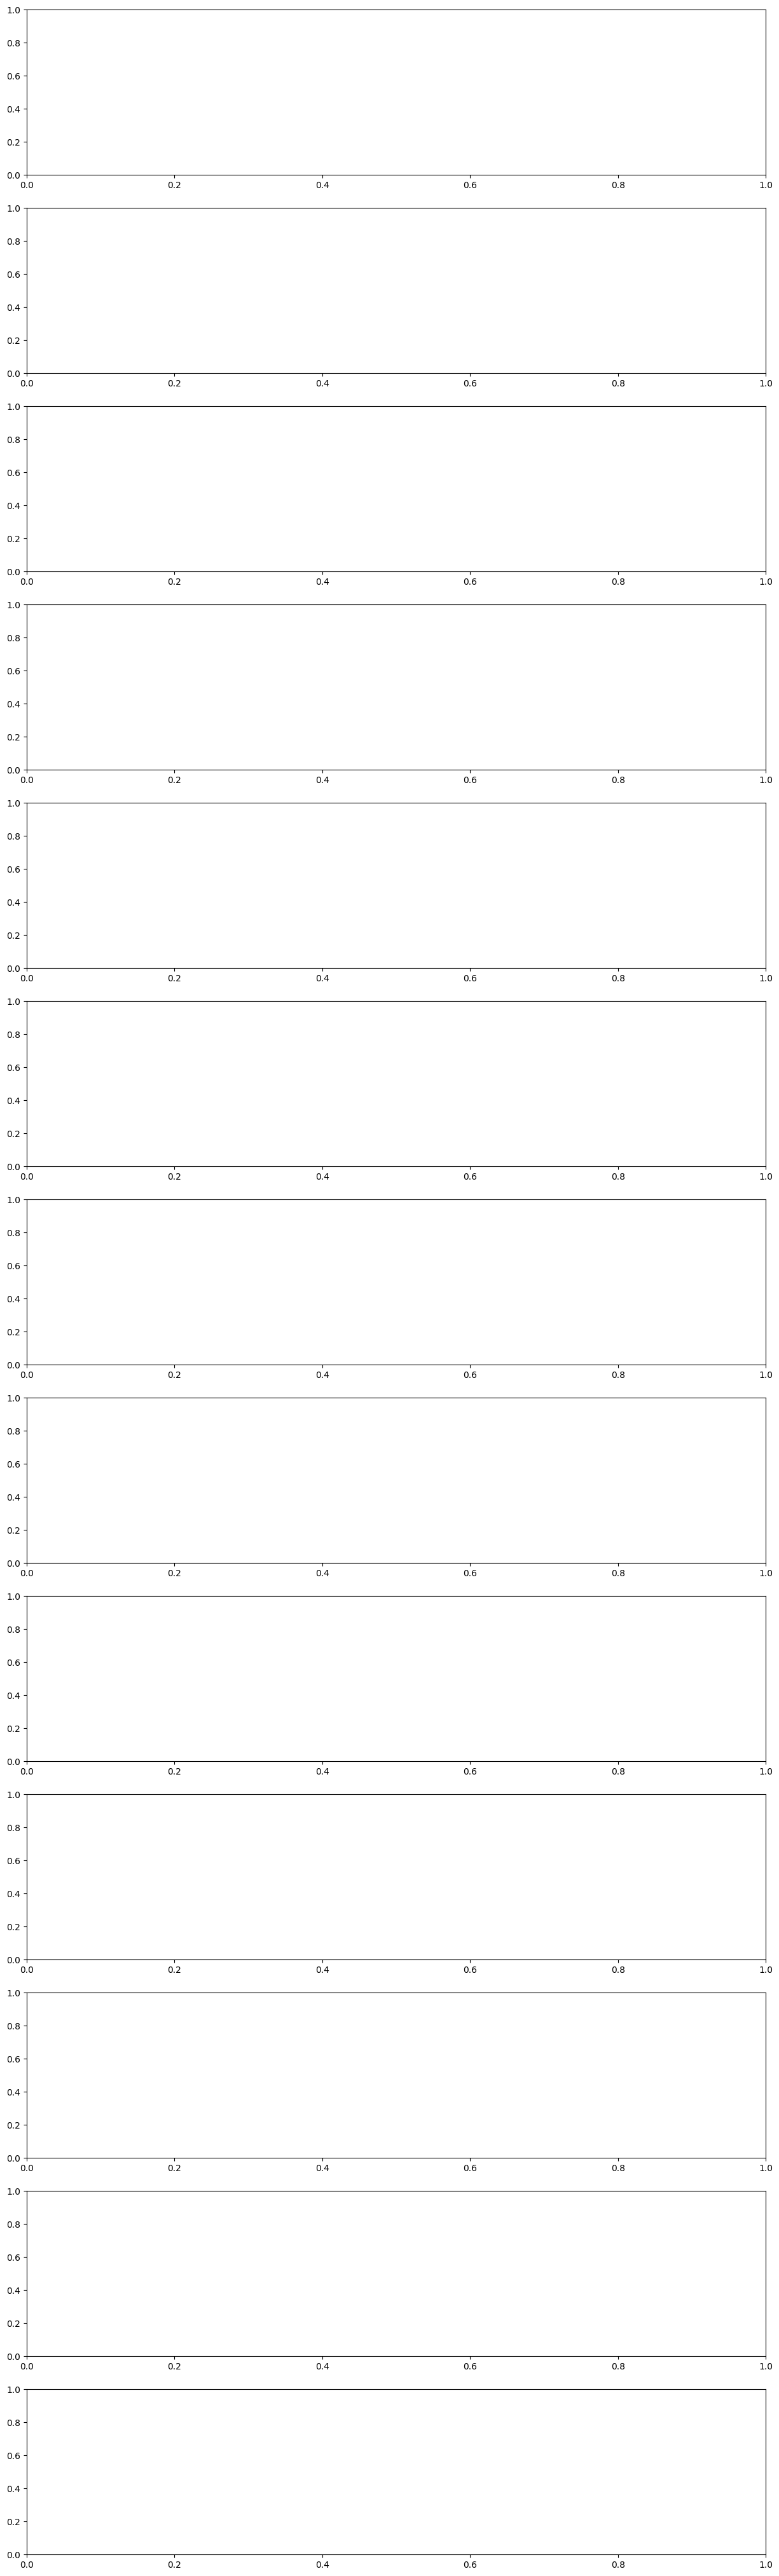

In [5]:
def plot_feature_time_series(average_experiment_features_per_frame, feature_keys):
    # Determine the number of strains
    strains = list(average_experiment_features_per_frame.keys())
    num_strains = len(strains)

    # Iterate through each feature key
    for feature_key in feature_keys:
        # Set up the plot grid
        fig, axs = plt.subplots(num_strains, 1, figsize=(15, num_strains * 4), squeeze=False)
        if num_strains == 1:
            axs = [axs[0, 0]]
        elif num_strains > 1:
            axs = axs.flatten()

        for i, strain in enumerate(strains):
            for exp_label, frames in average_experiment_features_per_frame[strain].items():
                # Prepare the data for plotting
                x = list(frames.keys())  # Frame indices
                y = [frame_data.get(feature_key, None) for frame_index, frame_data in frames.items() if frame_data]

                # Filter out None values for plotting
                filtered_data = [(xi, yi) for xi, yi in zip(x, y) if yi is not None]
                if not filtered_data:
                    continue

                x_filtered, y_filtered = zip(*filtered_data)

                # Plot the data in the respective subplot
                axs[i].plot(x_filtered, y_filtered, label=f"{exp_label}")

            axs[i].set_title(f"{strain} - {feature_key.capitalize()}")
            axs[i].set_xlabel('Frame Number')
            axs[i].set_ylabel(f"Average {feature_key.capitalize()}")
            axs[i].legend()

        plt.tight_layout()
        plt.show()

# Example usage
feature_keys = ['distance_from_center', 'area']  # Replace with the features you want to plot
average_experiment_features_per_frame = calculate_average_features_per_frame(experiment_features)
plot_feature_time_series(average_experiment_features_per_frame, feature_keys)

### Violin Plots for Each Strain (Separate Experiments) ###

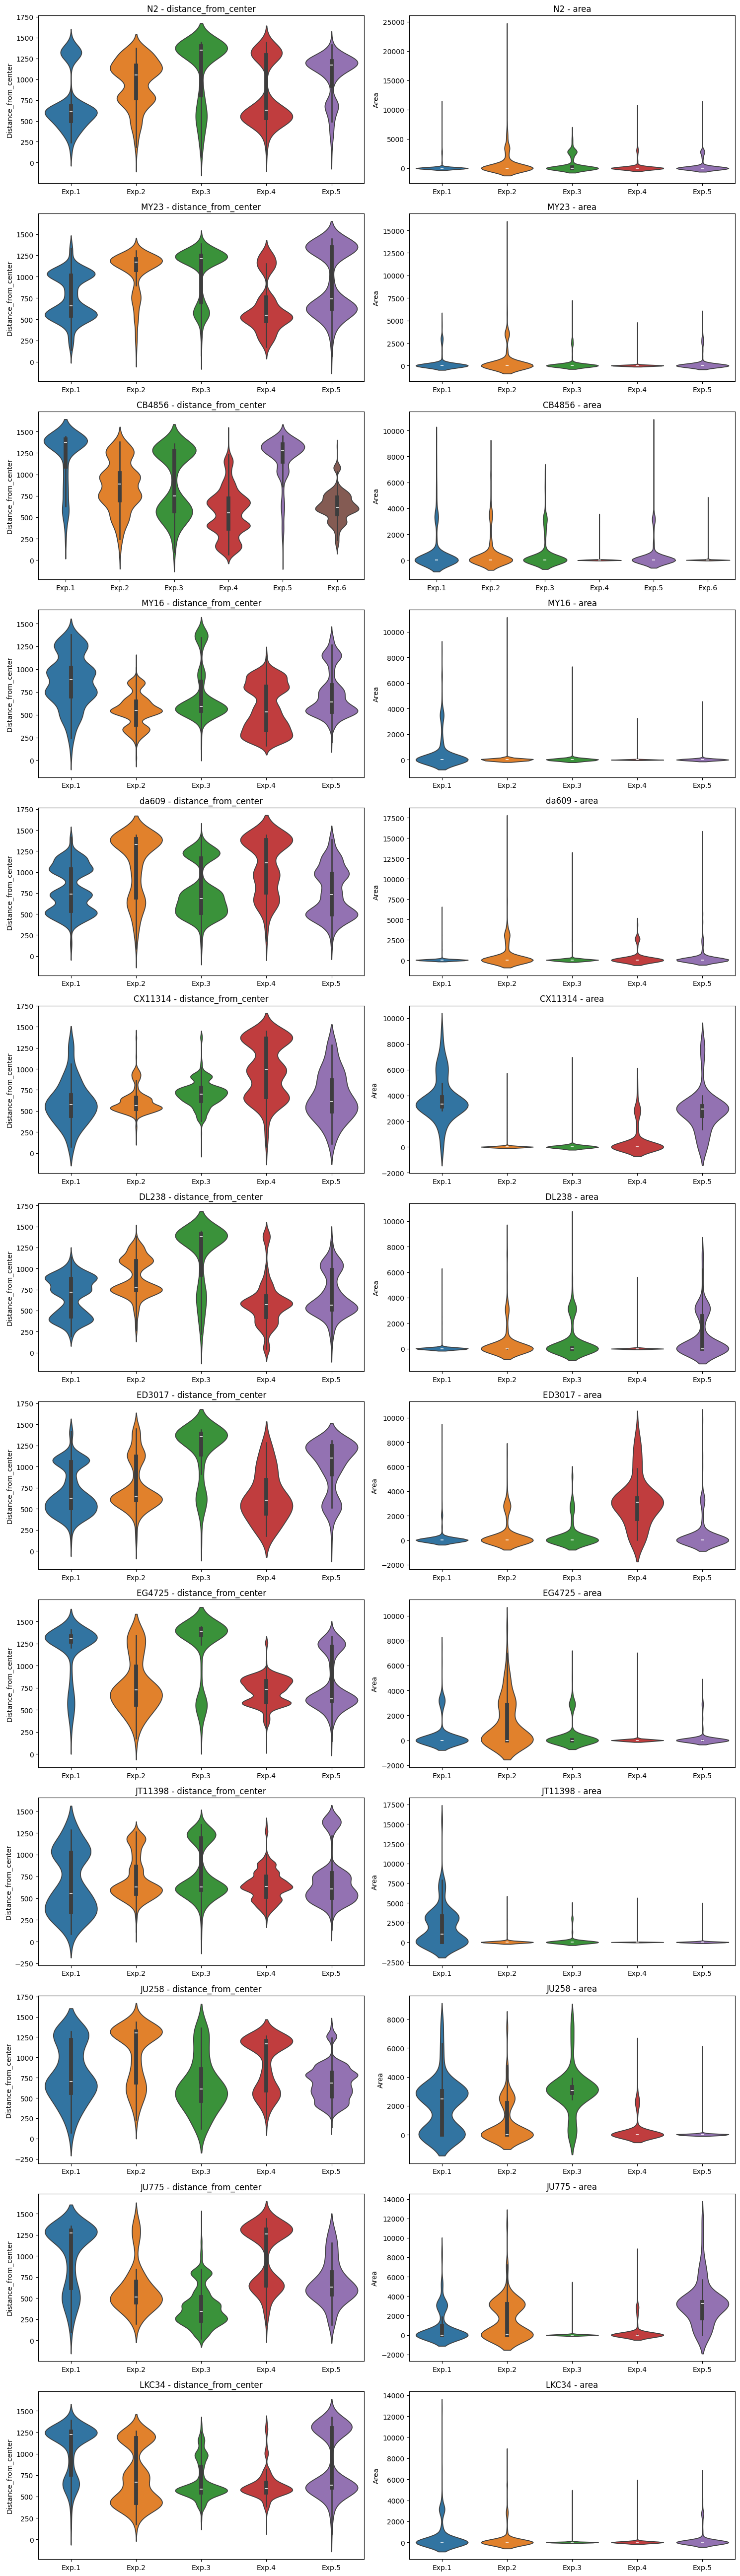

In [9]:
def plot_violin_plots(experiment_features):
    # Determine the number of unique features (excluding 'center_of_mass')
    sample_experiment = next(iter(next(iter(experiment_features.values())).values()))
    feature_keys = [key for key in sample_experiment[0].keys() if key != 'center_of_mass']

    num_strains = len(experiment_features)
    num_features = len(feature_keys)
    fig, axs = plt.subplots(num_strains, num_features, figsize=(15, num_strains * 4), squeeze=False)

    for i, (strain, experiments) in enumerate(experiment_features.items()):
        for j, feature_key in enumerate(feature_keys):
            data = []
            num_experiments = len(experiments)
            experiment_labels = [f"Exp.{k+1}" for k in range(num_experiments)]  # Generating labels like Exp.1, Exp.2, etc.

            for exp_label, features in experiments.items():
                feature_values = [feature[feature_key] for feature in features]
                data.append(feature_values)

            sns.violinplot(data=data, ax=axs[i, j])
            axs[i, j].set_title(f"{strain} - {feature_key}")
            axs[i, j].set_ylabel(feature_key.capitalize())
            axs[i, j].set_xticks(range(num_experiments))
            axs[i, j].set_xticklabels(experiment_labels)

    plt.tight_layout()
    plt.show()

plot_violin_plots(experiment_features)


### Average Time Series for All Strains ###

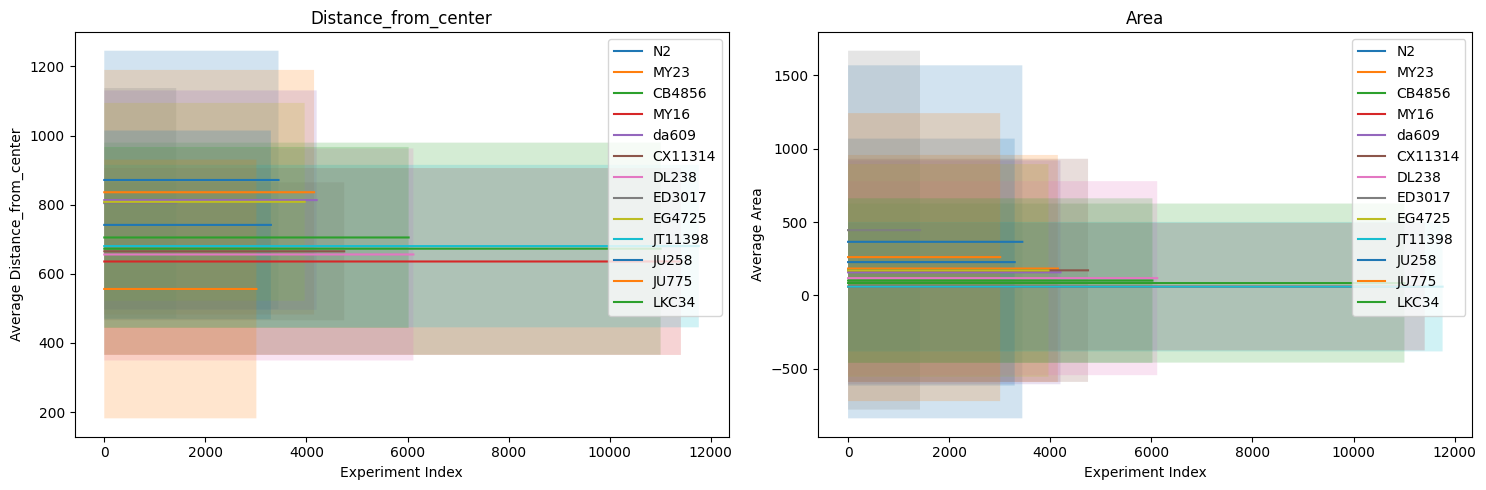

In [10]:
def plot_average_time_series(experiment_features):
    # Determine the number of unique features (excluding 'center_of_mass')
    sample_experiment = next(iter(next(iter(experiment_features.values())).values()))
    feature_keys = [key for key in sample_experiment[0].keys() if key != 'center_of_mass']

    num_features = len(feature_keys)
    fig, axs = plt.subplots(1, num_features, figsize=(15, 5), squeeze=False)
    axs = axs.flatten()

    for j, feature_key in enumerate(feature_keys):
        for strain, experiments in experiment_features.items():
            all_feature_values = []
            for exp_label, features in experiments.items():
                feature_values = [feature[feature_key] for feature in features]
                all_feature_values.extend(feature_values)

            avg_feature = np.mean(all_feature_values)
            std_feature = np.std(all_feature_values)
            x = range(len(all_feature_values))

            axs[j].plot(x, [avg_feature] * len(x), label=strain)  # Constant line for average
            axs[j].fill_between(x, [avg_feature - std_feature] * len(x), [avg_feature + std_feature] * len(x), alpha=0.2)

        axs[j].set_title(feature_key.capitalize())
        axs[j].set_xlabel('Experiment Index')
        axs[j].set_ylabel(f'Average {feature_key.capitalize()}')
        axs[j].legend()

    plt.tight_layout()
    plt.show()

plot_average_time_series(experiment_features)


### Violin Plots Averaging Over All Experiments for All Strains ###

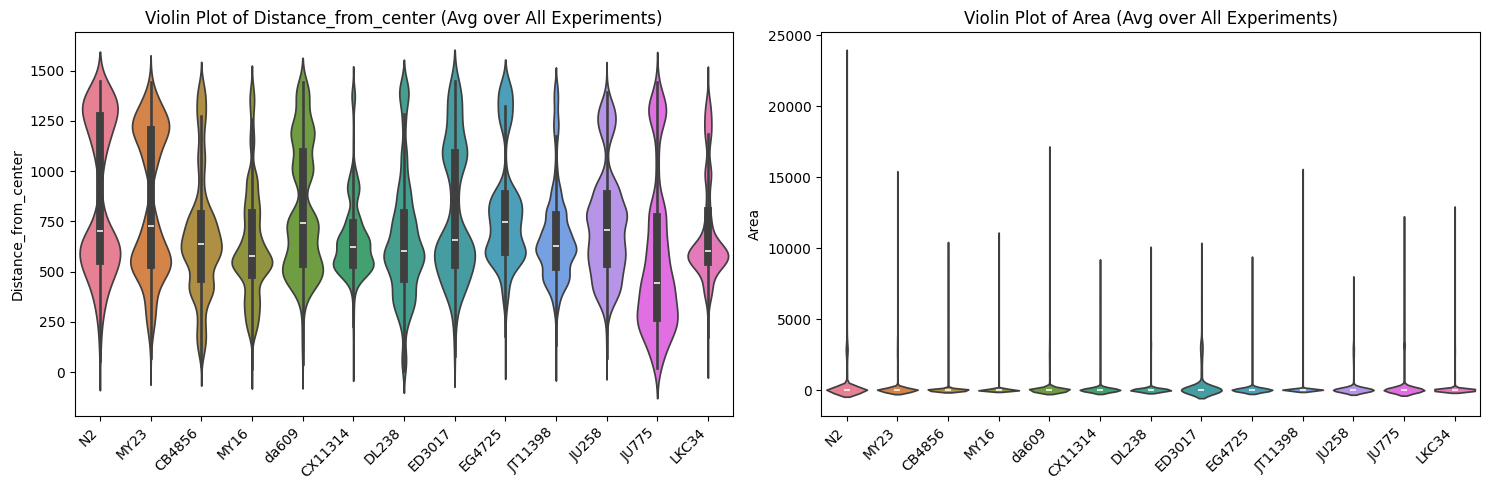

In [12]:
def plot_violin_plots_avg_all_experiments(experiment_features):
    # Determine the number of unique features (excluding 'center_of_mass')
    sample_experiment = next(iter(next(iter(experiment_features.values())).values()))
    feature_keys = [key for key in sample_experiment[0].keys() if key != 'center_of_mass']

    num_features = len(feature_keys)
    fig, axs = plt.subplots(1, num_features, figsize=(15, 5), squeeze=False)
    axs = axs.flatten()

    for j, feature_key in enumerate(feature_keys):
        feature_data = []

        for strain, experiments in experiment_features.items():
            all_feature_values = []
            for exp_label, features in experiments.items():
                feature_values = [feature[feature_key] for feature in features]
                all_feature_values.extend(feature_values)
            feature_data.append(all_feature_values)

        sns.violinplot(data=feature_data, ax=axs[j])
        axs[j].set_xticks(range(len(experiment_features)))
        axs[j].set_xticklabels(experiment_features.keys(), rotation=45, ha='right')  # Rotate labels for better readability
        axs[j].set_title(f"Violin Plot of {feature_key.capitalize()} (Avg over All Experiments)")
        axs[j].set_ylabel(feature_key.capitalize())

    plt.tight_layout()
    plt.show()

plot_violin_plots_avg_all_experiments(experiment_features)
